# Prediction: SVC

> **Warning!** Please run `01_cleaning.ipynb` first if you haven't already

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from functions.constants import BM_NAME, STARTDATE, ENDDATE, N_THRESHOLD_BPS,DATA_DIR
from functions.helper_fns import * 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

In [23]:
active_returns_path = DATA_DIR + BM_NAME + "_active_returns.csv"
active_returns = pd.read_csv(active_returns_path, index_col=0, parse_dates=True)
print("Loaded active returns from", active_returns_path)
active_returns_thresholded_path = DATA_DIR + BM_NAME + "_active_returns_thresholded_" + str(N_THRESHOLD_BPS) + "bps.csv"
active_returns_thresholded = pd.read_csv(active_returns_thresholded_path, index_col=0, parse_dates=True)
print("Loaded active returns thresholded from", active_returns_thresholded_path)

Loaded active returns from ./../data/SP500_active_returns.csv
Loaded active returns thresholded from ./../data/SP500_active_returns_thresholded_100bps.csv


In [24]:
TEST_TICKER = "GS UN" # Goldman Sachs--also try "AAPL UW" and "JPM UN"
test_ticker_df = active_returns_thresholded[active_returns_thresholded["Ticker"] == TEST_TICKER]
test_ticker_df.reset_index(drop=True, inplace=True)
test_ticker_df

,Ticker,Date,active_returns_1b,active_returns_1w,active_returns_1m,active_returns_1q,active_returns_1y
0,GS UN,2021-09-01,0.0,0.0,0.0,0.0,0.0
1,GS UN,2021-02-03,0.0,1.0,1.0,1.0,1.0
2,GS UN,2018-03-29,0.0,0.0,0.0,0.0,0.0
3,GS UN,2022-07-26,0.0,0.0,0.0,0.0,0.0
4,GS UN,2020-08-13,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
2447,GS UN,2015-09-18,0.0,0.0,0.0,0.0,0.0
2448,GS UN,2016-12-19,0.0,0.0,0.0,0.0,0.0
2449,GS UN,2018-08-06,0.0,0.0,0.0,0.0,0.0
2450,GS UN,2022-03-08,0.0,1.0,1.0,1.0,1.0


In [25]:
NUM_FEATURES = 12
PREDICTION_PERIOD = "1w"
MODEL_USING_DF = active_returns
# MODEL_USING_DF = test_ticker_df #turn this on to run for one company
df = featurize_time_series(MODEL_USING_DF, PREDICTION_PERIOD, NUM_FEATURES,set_threshold_for_target_var_bps=N_THRESHOLD_BPS)
target_var = "ar_" + PREDICTION_PERIOD + "_t"
X = df.drop(columns=[target_var, "Date", "Ticker"])
y = df[[target_var]]
print("X shape:", X.shape)
print(X.head())
print("y shape:", y.shape)
print(y.head())
X = X.to_numpy()
y = y.to_numpy()

X shape: (249991, 12)
    ar_1w_t_minus_1  ar_1w_t_minus_2  ar_1w_t_minus_3  ar_1w_t_minus_4  \
12         0.008647        -0.008387         0.008395         0.030798   
13        -0.020086         0.008647        -0.008387         0.008395   
14         0.022483        -0.020086         0.008647        -0.008387   
15         0.017339         0.022483        -0.020086         0.008647   
16         0.005448         0.017339         0.022483        -0.020086   

    ar_1w_t_minus_5  ar_1w_t_minus_6  ar_1w_t_minus_7  ar_1w_t_minus_8  \
12         0.006078        -0.007792         0.012361         0.018158   
13         0.030798         0.006078        -0.007792         0.012361   
14         0.008395         0.030798         0.006078        -0.007792   
15        -0.008387         0.008395         0.030798         0.006078   
16         0.008647        -0.008387         0.008395         0.030798   

    ar_1w_t_minus_9  ar_1w_t_minus_10  ar_1w_t_minus_11  ar_1w_t_minus_12  
12        -0

In [26]:
TEST_FRACTION = 0.2
EVAL_FRACTION = 0.2
X_train_and_eval, X_test, y_train_and_eval, y_test = train_test_split(X, y, test_size=TEST_FRACTION, shuffle=False)
X_train, X_eval, y_train, y_eval = train_test_split(X_train_and_eval, y_train_and_eval, test_size=EVAL_FRACTION/(1-TEST_FRACTION), shuffle=False)
print("X_train shape:", X_train.shape)
print("X_eval shape:", X_eval.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_eval shape:", y_eval.shape)
print("y_test shape:", y_test.shape)

X_train shape: (149994, 12)
X_eval shape: (49998, 12)
X_test shape: (49999, 12)
y_train shape: (149994, 1)
y_eval shape: (49998, 1)
y_test shape: (49999, 1)


## Train a simple SVC 

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
#Train an SVM model
model = SVC(probability=True,max_iter=5000, verbose=True, class_weight="balanced",kernel="linear")
model.fit(X_train, y_train.ravel()) #  # Use .ravel() to ensure y_train is a 1D array

[LibSVM]....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -4928.606631, rho = 0.660899
nSV = 5330, nBSV = 3918
Total nSV = 5330
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -4949.690473, rho = 0.648601
nSV = 5334, nBSV = 3854
Total nSV = 5334
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -4922.844015, rho = 0.698342
nSV = 5303, nBSV = 3855
Total nSV = 5303
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -4938.936440, rho = 0.664829
nSV = 5322, nBSV = 3896
Total nSV = 5322
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -4760.650038, rho = 0.615433
nSV = 5142, nBSV = 3763
Total nSV = 5142
Line search fails in two-class probability estimates
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -5821.241685, rho = 0.980025
nSV = 7285, nBSV = 3031
Total nSV = 7285


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(class_weight='balanced', kernel='linear', max_iter=5000, probability=True,
    verbose=True)

===TRAINING SET===
Accuracy: 0.34958731682600636
Precision: 0.3493466102486752
Recall: 0.9987025871937725
F1: 0.5176270482481731
ROC AUC: 0.5129051973318677
===EVALUATION SET===
Accuracy: 0.35813432537301493
Precision: 0.35670057496682883
Recall: 0.9947858264184795
F1: 0.5251117227500074
ROC AUC: 0.5052238189796583


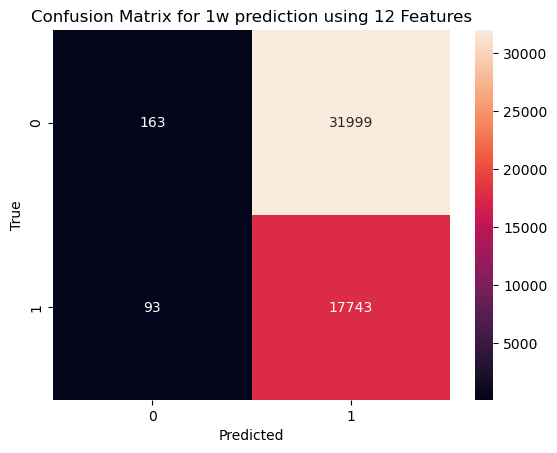

In [29]:
y_pred = model.predict(X_eval)
y_pred_proba = model.predict_proba(X_eval)
y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)
print("===TRAINING SET===")
evaluate_model_performance(y_train, y_train_pred, y_train_pred_proba,PREDICTION_PERIOD,NUM_FEATURES,plot_confusion_matrix=False)
print("===EVALUATION SET===")
evaluate_model_performance(y_eval, y_pred, y_pred_proba,PREDICTION_PERIOD,NUM_FEATURES)